In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [2]:
df = pd.read_excel("2010 Federal STEM Education Inventory Data Set.xls", skiprows = 1)

In [3]:
df.shape

(253, 256)

In [4]:
df.head()[:2]

,Index Number,Investment Name,Agency,Subagency,A) Brief Description,B) Year Established,C1) Funding FY2008,C2) Funding FY2009,C3) Funding FY2010,D) Mission-specific or General STEM?,...,Unnamed: 246,Unnamed: 247,Y3) Process or Implementation Evaluation Type,Unnamed: 249,Unnamed: 250,Y4) Portfolio Evaluation/Review Type,Unnamed: 252,Unnamed: 253,Y5) Expert Review Type,Unnamed: 255
0,PRG_0001,Centers for Ocean Sciences Education Excellence ~,National Science Foundation,Directorate for Geosciences (GEO),The Division of Ocean Sciences seeks to establ...,2002.0,5.24,7.19,5.7,General STEM,...,NaN,NaN,NaN,NaN,NO,INDEPENDENT,NaN,NaN,INDEPENDENT,NaN
1,PRG_0002,Broadening Participation in Computing (BPC),National Science Foundation,Directorate for Computer & Information Science...,The BPC Program was not primarily aimed at edu...,2006.0,14.00,14.00,14.0,General STEM,...,NaN,NaN,NaN,NaN,NO,NaN,NaN,NO,NaN,NaN


*There are many columns containing 'Unnamed : ' string because some columns are containing sub-columns.So while we are creating the dataframe, the first sub-column is getting the name of the column while others are Unnamed.For the sake of not overfilling this notebook for the univariate analysis (*Stage 2*), I am removing them from the dataframe.I can easily plot all of those columns but that will make this kernel more crowded.*

In [5]:
ct = [1 for column in df.columns if "Unnamed" in column]
len(ct)

207

In [6]:
cols = [column for column in df.columns if "Unnamed" not in column]
df = df[cols]

In [7]:
df.dtypes

Index Number                                                 object
Investment Name                                              object
Agency                                                       object
Subagency                                                    object
A) Brief Description                                         object
B) Year Established                                         float64
C1) Funding FY2008                                          float64
C2) Funding FY2009                                          float64
C3) Funding FY2010                                          float64
D) Mission-specific or General STEM?                         object
E) Agency or Mission-Related Workforce Needs?                object
F1) Primary Investment Objective                             object
F2) Secondary Investment Objectives                          object
G1) Primary Research Approaches                              object
G2) Secondary Research Approaches               

### Stage 1

*Percentage growth of funding between year 2008 & 2009*

In [8]:
df = df.dropna(subset = ('C2) Funding FY2009', 'C1) Funding FY2008'), axis = 0)
df['Growth'] = ((df['C2) Funding FY2009'] - df['C1) Funding FY2008']) / df['C1) Funding FY2008']) * 100

*If funding is positive, tag it as 1, if funding is negative tag it as 0. This is the target variable*

In [9]:
df['target'] = (df['Growth'] >= 0).astype(int)

### Stage 2

In [10]:
funding_cols = ['C1) Funding FY2008', 'C2) Funding FY2009', 'C3) Funding FY2010']
df_non_funding = df.drop(funding_cols, axis = 1)

In [11]:
df_non_funding.isnull().sum()

Index Number                                                  1
Investment Name                                               1
Agency                                                        1
Subagency                                                    15
A) Brief Description                                          1
B) Year Established                                           8
D) Mission-specific or General STEM?                          1
E) Agency or Mission-Related Workforce Needs?               130
F1) Primary Investment Objective                              1
F2) Secondary Investment Objectives                         107
G1) Primary Research Approaches                             217
G2) Secondary Research Approaches                           210
G3) Research Approaches Not Used                            151
H) Educational Services or Products Produced                123
I1) STEM Learners Targeted? Specify.                         38
I2) Pre-service-service STEM Teachers Ta

##### Lets remove the attributes with more than 50 missing values because columns with high number of missing values could not show the true picture of any case.

In [12]:
cols = df_non_funding.columns[df_non_funding.isnull().sum() < 50]
df_nf = df_non_funding[cols]

In [13]:
df_nf.columns

Index(['Index Number', 'Investment Name', 'Agency', 'Subagency',
       'A) Brief Description', 'B) Year Established',
       'D) Mission-specific or General STEM?',
       'F1) Primary Investment Objective',
       'I1) STEM Learners Targeted? Specify.',
       'J) Focus on Underrepresented Groups in STEM',
       'K) Eligibility Restrictions',
       'Q) Legislation Required to Shift Focus?', 'Growth', 'target'],
      dtype='object')

**Lets begin the univariate analysis**

* **Agency**

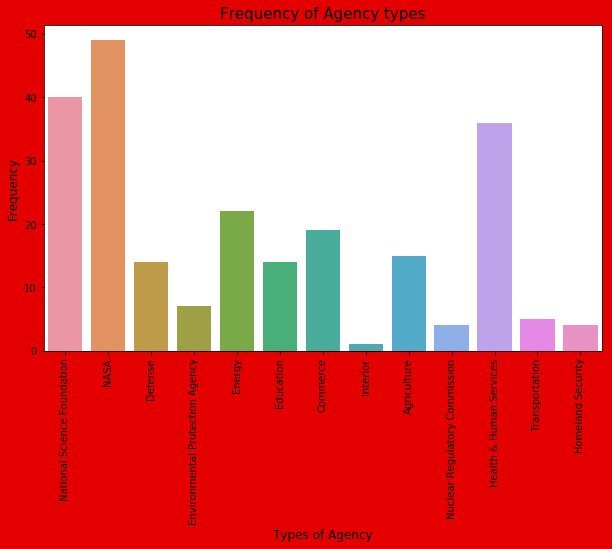

In [14]:
fig = plt.figure(figsize=(10,6))
fig.set_facecolor('xkcd:red')
sns.countplot(x="Agency", data = df_nf)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Types of Agency', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Agency types", fontsize=15)
plt.show()

* **Subagency**

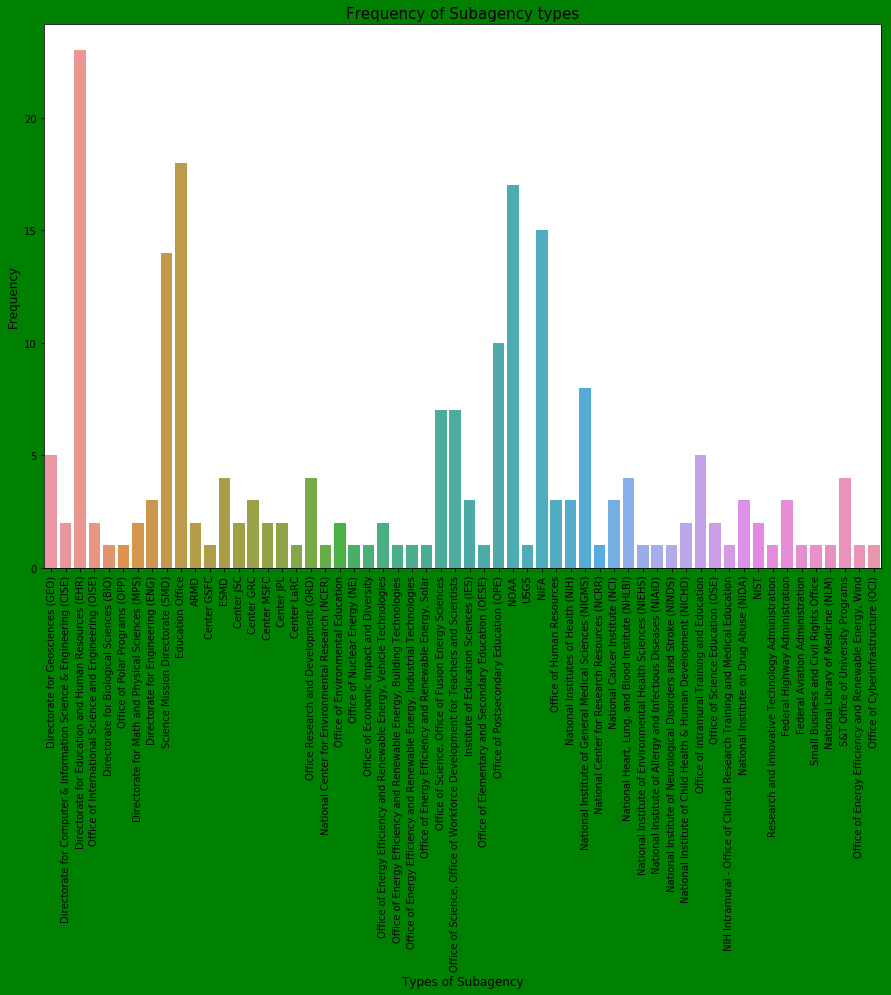

In [15]:
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('green')
sns.countplot(x="Subagency", data = df_nf)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Types of Subagency', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Subagency types", fontsize=15)
plt.show()

* **B) Year Established**

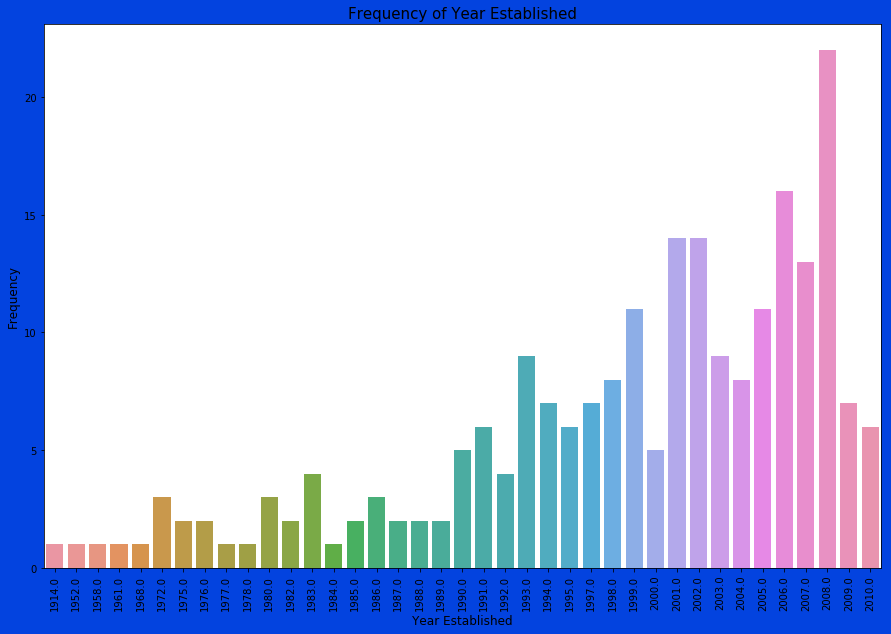

In [16]:
fig = plt.figure(figsize=(15,10))
fig.set_facecolor('xkcd:blue')
sns.countplot(x = "B) Year Established", data = df_nf)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Year Established', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Year Established", fontsize=15)
plt.show()

* **D) Mission-specific or General STEM?**

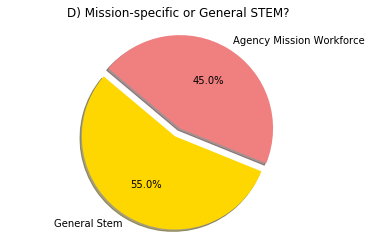

In [17]:
labels = 'General Stem', 'Agency Mission Workforce'
sizes = [138, 113] # The counts of the classes of D) Mission-specific or General STEM?
colors = ['gold','lightcoral']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('D) Mission-specific or General STEM?') 
plt.axis('equal')
plt.show()

* **I1) STEM Learners Targeted? Specify.**

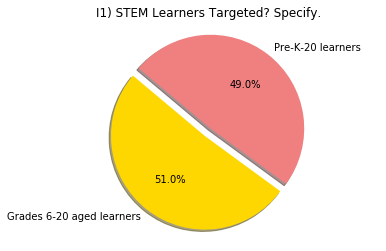

In [18]:
labels = df_nf.groupby('I1) STEM Learners Targeted? Specify.').sum()['target'].index[0], df_nf.groupby('I1) STEM Learners Targeted? Specify.').sum()['target'].index[1]
sizes = [df_nf.groupby('I1) STEM Learners Targeted? Specify.').sum()['target'][0], df_nf.groupby('I1) STEM Learners Targeted? Specify.').sum()['target'][1]] # The counts of the classes of I1) STEM Learners Targeted? Specify.
colors = ['gold','lightcoral']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('I1) STEM Learners Targeted? Specify.') 
plt.axis('equal')
plt.show()

* **J) Focus on Underrepresented Groups in STEM**

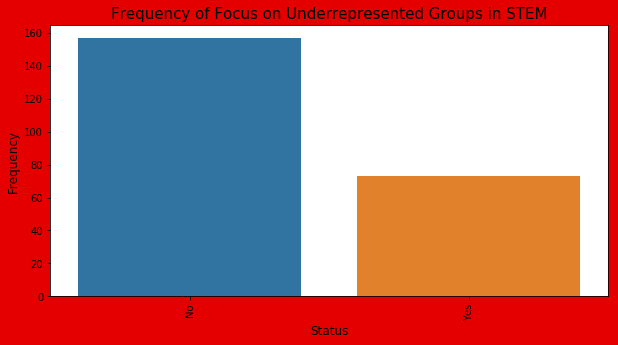

In [19]:
fig = plt.figure(figsize=(10,5))
fig.set_facecolor('xkcd:red')
sns.countplot(x = "J) Focus on Underrepresented Groups in STEM", data = df_nf)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Status', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Focus on Underrepresented Groups in STEM", fontsize=15)
plt.show()

* **K) Eligibility Restrictions**

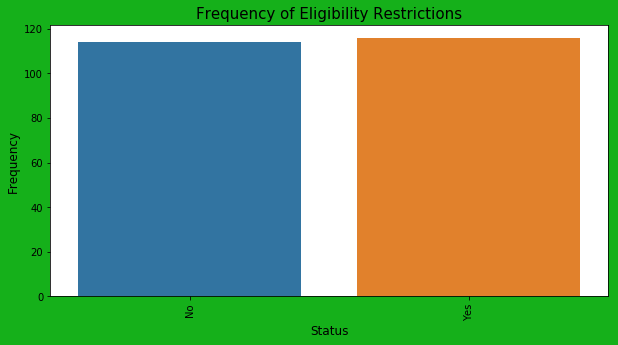

In [20]:
fig = plt.figure(figsize=(10,5))
fig.set_facecolor('xkcd:green')
sns.countplot(x = "K) Eligibility Restrictions", data = df_nf)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Status', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Eligibility Restrictions", fontsize=15)
plt.show()

* **Q) Legislation Required to Shift Focus?**

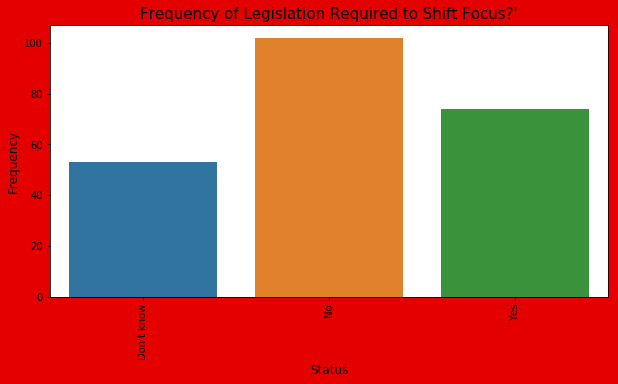

In [21]:
fig = plt.figure(figsize=(10,5))
fig.set_facecolor('xkcd:red')
sns.countplot(x = "Q) Legislation Required to Shift Focus?", data = df_nf)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Status', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Legislation Required to Shift Focus?'", fontsize=15)
plt.show()

* **Growth**

/home/ankit97/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


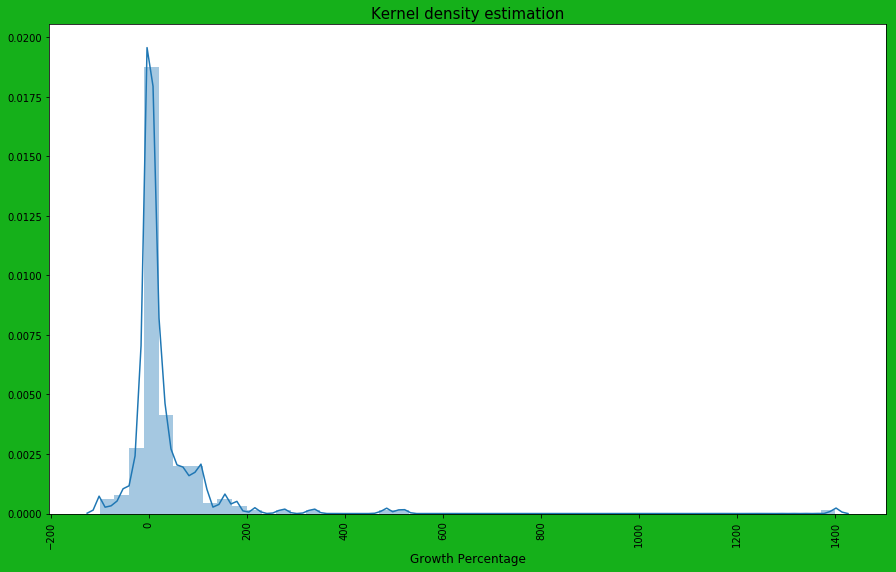

In [22]:
df_nf['Growth'] = df_nf['Growth'].replace([np.inf, -np.inf], np.nan)
fig = plt.figure(figsize=(15,9))
fig.set_facecolor('xkcd:green')
sns.distplot(df_nf['Growth'].dropna().astype(int))
plt.xlabel('Growth Percentage', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Kernel density estimation", fontsize=15)
plt.show()

In [23]:
print("Skewness: %f" % df_nf['Growth'].skew())
print("Kurtosis: %f" % df_nf['Growth'].kurt())

Skewness: 8.236412
Kurtosis: 89.052023


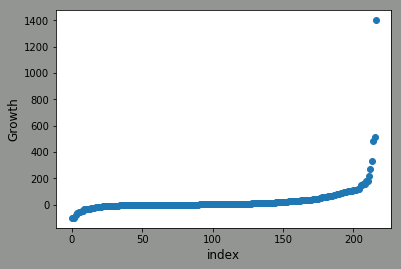

In [24]:
fig = plt.figure(figsize=(6,4))
fig.set_facecolor('xkcd:grey')
plt.scatter(range(df_nf.Growth.shape[0]), np.sort(df_nf.Growth.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Growth', fontsize=12)
plt.show()

**Mutual info Score**

In [25]:
from sklearn.cluster import KMeans
df_nf = df_nf.replace([np.inf, -np.inf], np.nan)
df_new = pd.get_dummies(df_nf.dropna())
kmeans = KMeans()
kmeans.fit_transform(df_new.drop('target', axis = 1))
print("Mutual info score : " + '{}'.format(mutual_info_score(df_new['target'], kmeans.labels_)))

Mutual info score : 0.21821240504292355


### Stage 3

**Divide data into train-test split**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_new.drop('target', axis = 1), df_new['target'], test_size = 0.3, random_state = 42)

**Select features & build xgboost model**

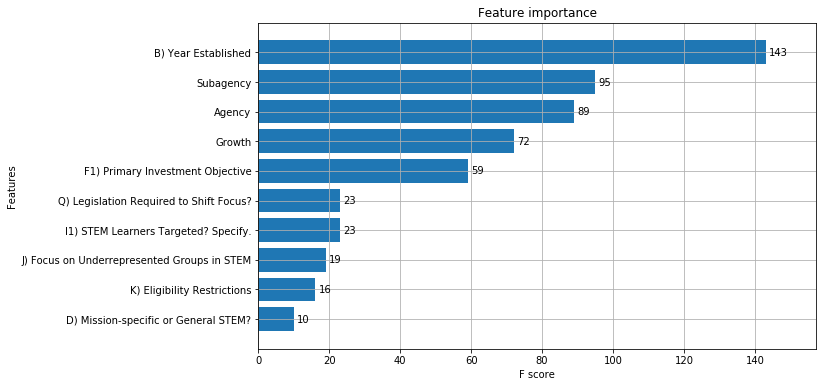

In [27]:
le = LabelEncoder()
object_cols = ['Agency', 'Subagency', 'D) Mission-specific or General STEM?', 'F1) Primary Investment Objective','J) Focus on Underrepresented Groups in STEM', 'I1) STEM Learners Targeted? Specify.', 'K) Eligibility Restrictions', 'Q) Legislation Required to Shift Focus?']
df_n = df_nf.drop(['A) Brief Description', 'Index Number', 'Investment Name'], axis = 1)
for cols in object_cols:
    df_n[cols] = le.fit_transform(df_n[cols].astype(str))
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(df_n.drop('target', axis = 1), df_n['target'], feature_names=df_n.drop('target', axis = 1).columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(10,6))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [28]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [29]:
print("ROC Score : " + '{}'.format(roc_auc_score(y_test, y_pred)))

ROC Score : 1.0
